<a href="https://colab.research.google.com/github/yihaozhong/479_data_management/blob/main/Boston_Data_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boosted Trees 

Matt Zeidenberg


## Problems with Decision Tree Models that Use a Single Tree
* Decision trees of arbitrary depth can fit training data well, but often overfit it
* Single tree models are not competitive with other popular machine learning methods (e.g. support vector machines)
* It turns out that ensembles of trees working together perform better than single trees
   * Tree ensemble methods are competitive ML methods
* Two tree-based ensemble methods that are popular are Random Forests (a bagging method) and Gradient Boosting 

## Gradient Boosting as an Ensemble Model

* Uses a large number of trees 
* Each tree fits the residual that was not fit by the trees used before it
* Thus fit on the training data improves as each tree is added
* Trees are limited in height; can actually use stumps (two leaves only) if desired
* Characterized by a shrinkage parameter lambda which limits the contribution of any particular tree
  * Slow learning is better
* Hyperparameters: tree height, number of trees, lambda

$
\begin{align}
e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i
\end{align}
$

In [ ]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
# License: BSD 3 clause
# example from https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import statsmodels.api as sm

from sklearn import linear_model
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import tree

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Learning Objectives
1. Understand boosting in the context of ensemble learning methods
2. Understand gradient boosting as an example of boosting
3. Run an example of Gradient Boosting in Python using scikit-learn and understand the results
4. Tune hyperparameters and see what the result is

# Boston Housing Data
see http://math.furman.edu/~dcs/courses/math47/R/library/mlbench/html/BostonHousing.html

Housing data for 506 census tracts in Boston from the 1970 Census

* CRIM: per capita crime rate (for town)
* ZN: proportion of residential land zoned for lots over 25,000 sq.ft
* INDUS: proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: nitric oxides concentration (parts per 10 million)
* RM: average number of rooms per dwelling
* AGE: proportion of owner-occupied units built prior to 1940
* DIS: weighted distances to five Boston employment centres
* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per USD 10,000
* PTRATIO: pupil-teacher ratio by town
* B: 1000(B - 0.63)^2 where B is the proportion of blacks by town
* LSTAT: percentage of lower status of the population
* MEDV: median value of owner-occupied homes in USD 1000's (TARGET)

In [ ]:
# Load data
boston = datasets.load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.1, random_state=42)
boston_df = pd.DataFrame(np.c_[boston.data, boston.target],columns=np.append(boston.feature_names, ["target"]))
boston_df.head(5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


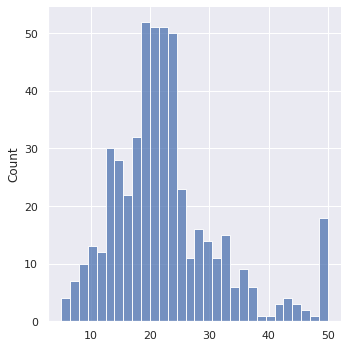

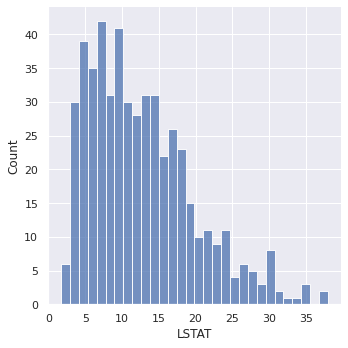

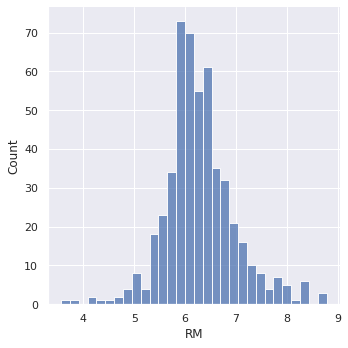

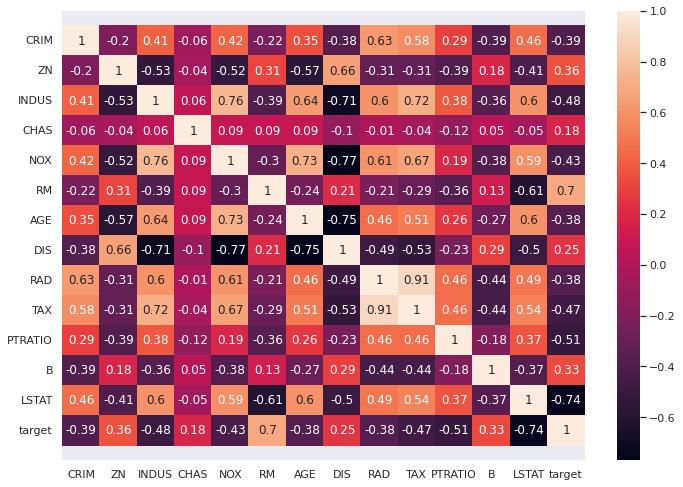

In [ ]:
# adapted from https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(boston.target, bins=30)
plt.show()
sns.displot(boston_df['LSTAT'], bins=30)
plt.show()
sns.displot(boston_df['RM'], bins=30)
plt.show()
correlation_matrix = boston_df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [ ]:
X2 = sm.add_constant(boston.data)
model = sm.OLS(boston.target, X2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 31 Jan 2022   Prob (F-statistic):          6.72e-135
Time:                        01:55:28   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

In [ ]:
reg=linear_model.LinearRegression()
reg.fit(X_train,y_train) 
mse = mean_squared_error(y_test,reg.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 14.9959


In [ ]:
# Fit Gradient Boosting regression model
# loss function is least squares
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


MSE: 5.6338


Text(0, 0.5, 'MSE')

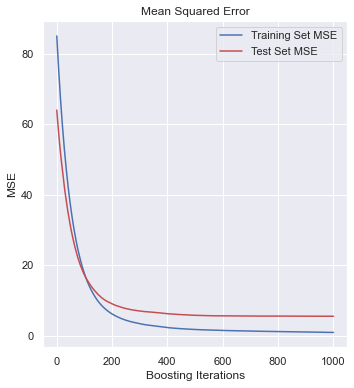

In [ ]:
# Plot test and training loss

# compute test set loss
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Mean Squared Error')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')

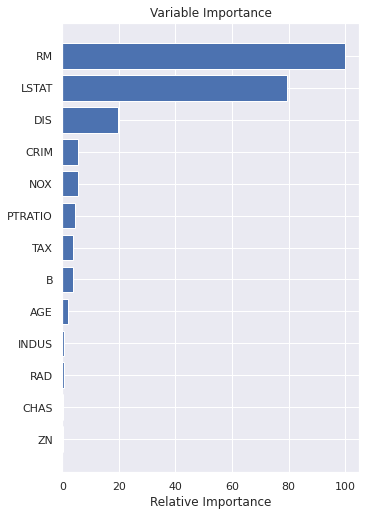

In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

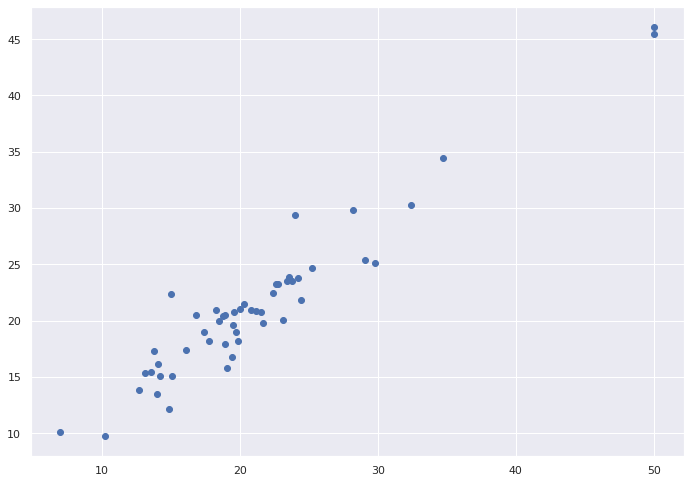

In [ ]:
plt.scatter(y_test,clf.predict(X_test))